<a href="https://colab.research.google.com/github/pedrogfsilva/atividadePredicaoSerieTemporal/blob/main/Atividade_predi%C3%A7%C3%A3o_de_uma_s%C3%A9rie_temporal_Pedro_Silva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Conjunto de dados de série temporal do Kaggle

Este dataset contém informações sobre o clima em Delhi na Índia, abrangendo o período de 1º de janeiro de 2013 a 24 de abril de 2017. Os parâmetros incluídos são temperatura média, umidade, velocidade do vento, pressão média e data.

Link do dataset: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [26]:
import pandas as pd

In [27]:
df = pd.read_csv('/content/drive/MyDrive/predicaoSerieTemporal/DailyDelhiClimateTrain.csv')

In [28]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


### Modelo de predição desta série temporal utilizando Prophet.



In [29]:
!pip install prophet

In [30]:
# importando pacotes utilizados
from prophet import Prophet
import matplotlib.pyplot as plt

In [31]:
# renomeando colunas e convertendo coluna date para datetime
df.rename(columns={'date': 'ds', 'meantemp': 'y'}, inplace=True)

df['ds'] = pd.to_datetime(df['ds'])

In [32]:
# criando o modelo e ajustando modelo aos dados
model = Prophet()

model.fit(df[['ds', 'y']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_xxcrh3w/y6pq6_36.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_xxcrh3w/v72hm8pz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80695', 'data', 'file=/tmp/tmp_xxcrh3w/y6pq6_36.json', 'init=/tmp/tmp_xxcrh3w/v72hm8pz.json', 'output', 'file=/tmp/tmp_xxcrh3w/prophet_modeljajdh41v/prophet_model-20241005164232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
future = model.make_future_dataframe(periods=30)  # previsão de 30 dias à frente

# fazendo previsões
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


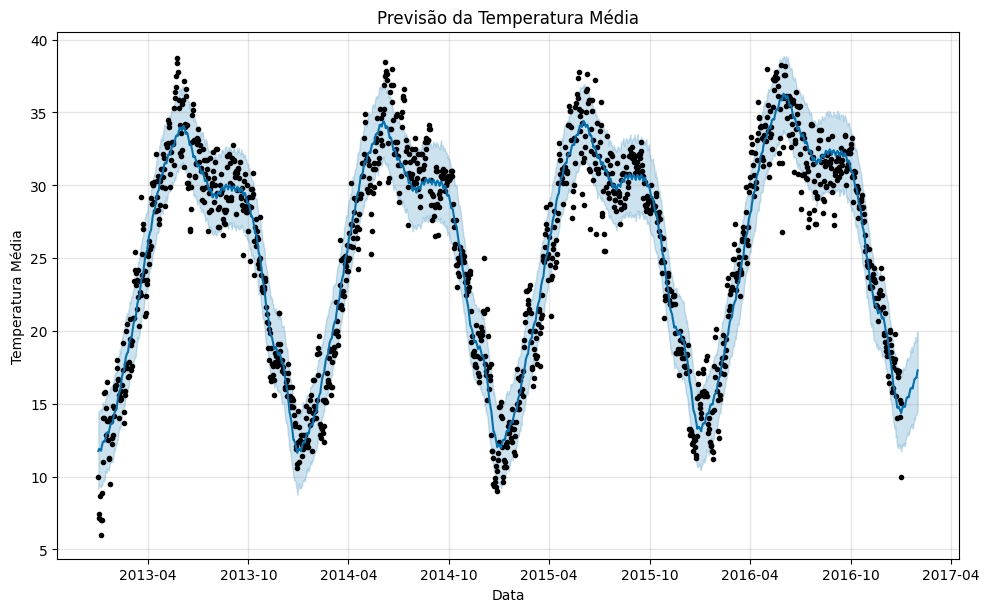

In [34]:
# resultados
fig = model.plot(forecast)
plt.title('Previsão da Temperatura Média')
plt.xlabel('Data')
plt.ylabel('Temperatura Média')
plt.show()

### Modelo de predição desta série temporal utilizando LSTM.

In [35]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [36]:
# renomeando as colunas e convertendo a coluna de data para datetime
df.rename(columns={'date': 'ds', 'meantemp': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# normalização das colunas
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['y']])

# dividindo dados entre treino e teste
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled[0:train_size], data_scaled[train_size:]

In [37]:
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# número de passos do tempo
time_step = 30

X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [38]:
# criando o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# treinando o modelo
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.1018
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0093
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0078
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0071
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0071
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0075
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0074
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0063
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0064
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0061
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0060
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0065
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0051
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0058
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0056
Epoch 16/50
36/

In [39]:
# previsões no conjunto de teste
predictions = model.predict(X_test)

# invertendo a normalização das previsões
predictions = scaler.inverse_transform(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


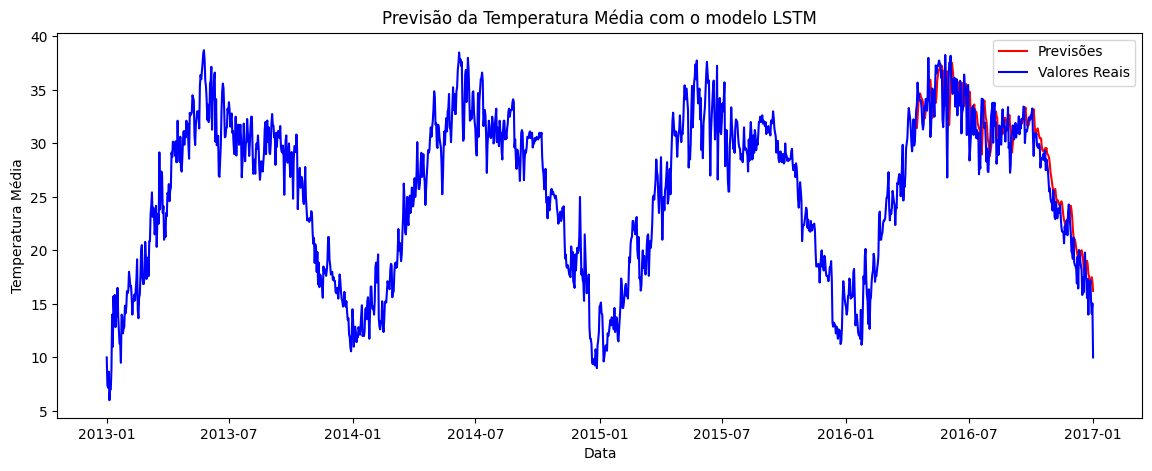

In [40]:
# gráfico dos resultados
plt.figure(figsize=(14, 5))
plt.plot(df['ds'][train_size + time_step + 1:], predictions, color='red', label='Previsões')
plt.plot(df['ds'], df['y'], color='blue', label='Valores Reais')
plt.title('Previsão da Temperatura Média com o modelo LSTM')
plt.xlabel('Data')
plt.ylabel('Temperatura Média')
plt.legend()
plt.show()

### Métrica de Erro escolhida - RMSE

O RMSE é uma métrica bastante utilizada na avaliação de modelos de previsão, principalmente em séries temporais. Uma das principais razões para sua escolha é a sua sensibilidade a erros grandes. O RMSE penaliza mais severamente desvios significativos entre os valores previstos e os reais, o que é importante em contextos onde grandes erros podem ter consequências graves. Além disso, o RMSE é expresso nas mesmas unidades que os dados originais, o que facilita a interpretação dos resultados.

Por fim, o RMSE também permite comparações diretas entre diferentes modelos aplicados à mesma série temporal, ajudando na identificação do modelo mais eficaz. Essa característica de comparabilidade é fundamental para a melhoria contínua dos modelos preditivos (Hyndman & Athanasopoulos, 2018).

Referência: Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: Principles and Practice

In [41]:
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(np.mean((y_test_actual - predictions) ** 2))

print(f'RMSE: {rmse:.2f}')

RMSE: 1.83
